# Vision Transformer

[An Image is Worth 16x16 Words](https://arxiv.org/abs/2010.11929v2)

[Vision Transformer for Small-Size Datasets](https://arxiv.org/pdf/2112.13492.pdf) *todo*

[Training Vision Transformers with Only 2040 Images](https://arxiv.org/abs/2201.10728) *todo*



## Model Notes
* P = patch size
* N = number of patches
* transform image from (H,W,C) to (N,P\*\*2 \*C) where
* also prepend a class token
* GeLU activation in MLP layers

## TODO
* fix always predicting same class

In [119]:
# download pretrained weights for Cifar100 trained model
!wget https://storage.googleapis.com/vit_models/augreg/B_16-i1k-300ep-lr_0.001-aug_light0-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224.npz
# !wget https://storage.googleapis.com/vit_models/augreg/B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_224.npz


--2023-01-14 04:28:08--  https://storage.googleapis.com/vit_models/augreg/B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_224.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346335542 (330M) [application/octet-stream]
Saving to: ‘B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_224.npz.1’

B_16-i21k-300ep-lr_ 100%[===================>] 330.29M  26.1MB/s    in 14s     

2023-01-14 04:28:23 (24.1 MB/s) - ‘B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_224.npz.1’ saved [346335542/346335542]



In [48]:
# CIFAR100 class names
class_names  = [
    'apple',
    'aquarium_fish',
    'baby',
    'bear',
    'beaver',
    'bed',
    'bee',
    'beetle',
    'bicycle',
    'bottle',
    'bowl',
    'boy',
    'bridge',
    'bus',
    'butterfly',
    'camel',
    'can',
    'castle',
    'caterpillar',
    'cattle',
    'chair',
    'chimpanzee',
    'clock',
    'cloud',
    'cockroach',
    'couch',
    'crab',
    'crocodile',
    'cup',
    'dinosaur',
    'dolphin',
    'elephant',
    'flatfish',
    'forest',
    'fox',
    'girl',
    'hamster',
    'house',
    'kangaroo',
    'computer_keyboard',
    'lamp',
    'lawn_mower',
    'leopard',
    'lion',
    'lizard',
    'lobster',
    'man',
    'maple_tree',
    'motorcycle',
    'mountain',
    'mouse',
    'mushroom',
    'oak_tree',
    'orange',
    'orchid',
    'otter',
    'palm_tree',
    'pear',
    'pickup_truck',
    'pine_tree',
    'plain',
    'plate',
    'poppy',
    'porcupine',
    'possum',
    'rabbit',
    'raccoon',
    'ray',
    'road',
    'rocket',
    'rose',
    'sea',
    'seal',
    'shark',
    'shrew',
    'skunk',
    'skyscraper',
    'snail',
    'snake',
    'spider',
    'squirrel',
    'streetcar',
    'sunflower',
    'sweet_pepper',
    'table',
    'tank',
    'telephone',
    'television',
    'tiger',
    'tractor',
    'train',
    'trout',
    'tulip',
    'turtle',
    'wardrobe',
    'whale',
    'willow_tree',
    'wolf',
    'woman',
    'worm',
]
print(len(class_names))

100


In [92]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import math

In [50]:
transforms = T.Compose([T.ToTensor(), T.Resize(224)])
test_ds = datasets.CIFAR100(
    root='data',
    train=False,
    transform=transforms,
    download=True,
)
test_dl = DataLoader(
    test_ds, batch_size=1, shuffle=True,
)

Files already downloaded and verified


In [115]:
class MultiHeadedAttn(nn.Module):
    def __init__(self, dmodel, num_heads):
        super().__init__()
        assert(dmodel % num_heads == 0)
        self.dmodel = dmodel
        self.num_heads = num_heads
        # remember to transpose pretrained weights 
        self.query = nn.Linear(dmodel, dmodel)
        self.key = nn.Linear(dmodel, dmodel)
        self.value = nn.Linear(dmodel, dmodel)
        self.out = nn.Linear(dmodel, dmodel)

    def forward(self, x):
        # (bs, seq_len, dmodel) -> (bs, seq_len, num_heads, head_size)
        q, k, v = [y(x).reshape(x.shape[0], -1, 
                                self.num_heads, self.dmodel//self.num_heads)
                    for y in [self.query, self.key, self.value]]
        # (bs, num_heads, seq_len, head_size)
        q, k, v = [y.permute(0, 2, 1, 3) for y in [q, k, v]]

        out = q @ k.transpose(2, 3) * (1/math.sqrt(self.dmodel//self.num_heads))
        out = torch.softmax(out, dim=-1)
        # back to (bs, seq_len, dmodel)
        out = (out @ v).permute(0, 2, 1, 3)
        out = out.reshape(x.shape[0], -1, self.dmodel)
        out = self.out(out)
        return out

class MLPBlock(nn.Module):
    def __init__(self, dmodel):
        super().__init__()
        self.ff1 = nn.Linear(dmodel, dmodel*4)
        self.ff2 = nn.Linear(dmodel*4, dmodel)
    def forward(self, x):
        x = torch.dropout(F.gelu(self.ff1(x)), 0.1, train=False)
        x = torch.dropout(self.ff2(x), 0.1, train=False)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, dmodel, num_heads):
        super().__init__()
        self.attn = MultiHeadedAttn(dmodel, num_heads)
        self.mlp = MLPBlock(dmodel)
        self.norm1 = nn.LayerNorm(dmodel)
        self.norm2 = nn.LayerNorm(dmodel)

    def forward(self, x):
        tmp = self.norm1(x)
        tmp = torch.dropout(self.attn(tmp), 0.1, train=False)
        x = x + tmp
        tmp = self.norm2(x)
        tmp = self.mlp(tmp)
        x = x + tmp
        return x

class Encoder(nn.Module):
    def __init__(self, dmodel, num_heads, num_encoders):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.ones(1, 197, dmodel))
        encoder_blocks = [
            EncoderBlock(dmodel, num_heads)
            for _ in range(num_encoders)
        ]
        self.model = nn.Sequential(*encoder_blocks)     
        self.norm = nn.LayerNorm(dmodel)

    def forward(self, x):
        x = torch.dropout(x + self.pos_embedding, 0.1, train=False)
        x = self.model(x)
        x = self.norm(x)
        return x

In [72]:
# full base ViT
class VisionTransformer(nn.Module):
    def __init__(self, emb_dim, num_classes):
        super().__init__()
        self.embedding = nn.Conv2d(3, emb_dim, 16, 16, padding='valid')
        # 197 = (224/16) ** 2
        self.cls = nn.Parameter(torch.ones((1, 1, emb_dim)))
        self.emb_dim = emb_dim
        self.encoder = Encoder(emb_dim, 12, 12)
        # self.pre_logits = nn.Parameter(torch.rand(emb_dim))
        self.head = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        # (bs, seq_len,emb_dim)
        x = x.reshape(x.shape[0], x.shape[1], -1).permute(0, 2, 1)
        # prepend class embedding token
        # (bs, 1, emb_dim)
        cls_emb = self.cls + torch.zeros(x.shape[0], 1, 1)
        x = torch.cat((cls_emb, x), dim=1)
        x = self.encoder(x)
        x = x[:, 0]
        x = self.head(x)
        return x

    def load_from_pretrained(self, path):
        with np.load(path) as data:
            params = self.state_dict()
            params['encoder.pos_embedding'] = torch.from_numpy(data['Transformer/posembed_input/pos_embedding'])
            params['cls'] = torch.from_numpy(data['cls'])
            params['embedding.weight'] = torch.from_numpy(data['embedding/kernel']).permute(3, 2, 0, 1)
            params['embedding.bias'] = torch.from_numpy(data['embedding/bias'])
            params['encoder.norm.weight'] = torch.from_numpy(data['Transformer/encoder_norm/scale'])
            params['encoder.norm.bias'] = torch.from_numpy(data['Transformer/encoder_norm/bias'])
            # params['pre_logits.weight'] = torch.from_numpy(data['pre_logits/kernel']).T
            # params['pre_logits.bias'] = torch.from_numpy(data['pre_logits/bias'])
            params['head.weight'] = torch.from_numpy(data['head/kernel']).T
            params['head.bias'] = torch.from_numpy(data['head/bias'])
            for i in range(12):
                params[f'encoder.model.{i}.attn.query.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/query/kernel']).reshape(768, -1).T
                params[f'encoder.model.{i}.attn.query.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/query/bias']).reshape(-1)
                params[f'encoder.model.{i}.attn.key.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/key/kernel']).reshape(768, -1).T
                params[f'encoder.model.{i}.attn.key.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/key/bias']).reshape(-1)
                params[f'encoder.model.{i}.attn.value.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/value/kernel']).reshape(768, -1).T
                params[f'encoder.model.{i}.attn.value.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/value/bias']).reshape(-1)
                params[f'encoder.model.{i}.attn.out.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/out/kernel']).T.reshape(768, -1).T
                params[f'encoder.model.{i}.attn.out.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/out/bias'])
                params[f'encoder.model.{i}.mlp.ff1.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_0/kernel']).T
                params[f'encoder.model.{i}.mlp.ff1.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_0/bias'])
                params[f'encoder.model.{i}.mlp.ff2.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_1/kernel']).T
                params[f'encoder.model.{i}.mlp.ff2.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_1/bias'])
                params[f'encoder.model.{i}.norm1.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_0/scale'])
                params[f'encoder.model.{i}.norm1.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_0/bias'])
                params[f'encoder.model.{i}.norm2.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_2/scale']).T
                params[f'encoder.model.{i}.norm2.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_2/bias'])
            self.load_state_dict(params)

In [120]:
path = 'B_16-i1k-300ep-lr_0.001-aug_light0-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224.npz'
# path = 'B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_224.npz'
model = VisionTransformer(768, 1000)
model.load_from_pretrained(path)

In [ ]:
for p in model.state_dict():
    print(p)

tensor([[-8.9409e-01,  6.0453e-01, -6.1544e-01, -4.2042e-01, -1.2260e+00,
         -8.3103e-01, -8.1318e-01, -7.1317e-01,  3.8062e-01,  6.4654e-01,
         -4.6651e-01,  1.2452e+00,  5.5023e-01, -2.2974e-01,  7.9649e-01,
          2.0593e-01,  1.3065e-01,  3.2764e-01,  1.4940e-01,  1.3664e+00,
         -7.7949e-01, -1.1485e+00, -2.8816e-01,  8.5736e-01, -9.6083e-01,
          2.8477e-01, -1.5612e-01,  3.8164e-01,  5.0972e-01, -1.9322e-02,
          2.4492e-01,  1.0517e+00,  4.9239e-01, -9.3724e-01,  3.6830e-02,
          7.5813e-01,  6.8908e-01,  3.7325e-01, -1.3000e+00,  1.4365e-01,
         -5.7760e-01, -1.2286e-01, -1.8084e+00, -2.7398e+00, -2.1603e-01,
          1.9195e-01,  6.1293e-01, -3.6065e-01,  2.0472e-01, -1.5451e+00,
         -2.9129e-01,  8.2915e-01, -3.7776e-01, -7.4153e-01, -2.3602e+00,
          1.7144e+00, -1.0987e+00,  2.2457e-01, -1.0157e-01,  4.3733e-01,
         -1.1157e+00, -7.8817e-01, -5.0921e-01, -2.1255e+00,  1.0710e-01,
         -9.0491e-01, -6.8188e-01, -1.

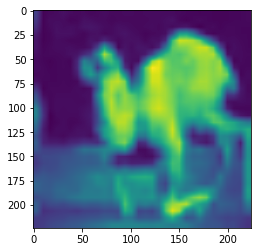

In [130]:
model.eval()
# always predicting cls=3?
for (i, (x, _)) in enumerate(test_dl):
    plt.imshow(x.squeeze(0)[0])
    if i > 0: break
    out = model(x)
    print(out)
    cls = out.argmax(dim=-1).item()
    print(cls, class_names[cls])